# Ocean Color Data & Model Recipes

Here we set out to compare [CBIOMES model output](https://cbiomes.readthedocs.io/en/latest/) with [ocean color data](https://www.oceancolour.org). 

<img src="../figs/cbiomes-01.png" alt="Drawing" style="height: 100px;"/>

_Notebooks are written in [Julia](https://julialang.org) and reproducible via [binder](https://mybinder.org/v2/gh/gaelforget/Cbiomes2019Notebooks/master)._

### Activate packages for later use

It is assumed that listed packages have aleary been installed using `julia`'s package manager (documentation available [here](https://docs.julialang.org/en/)). 

In [1]:
using Plots, Distributions, NetCDF

### Model and data wavebands

Currently, the `OC-CCI` [satellite data set](https://esa-oceancolour-cci.org) provides remotely sensed reflectance at 6 wavelengths (`wv_cci` in `nm`) while the `CBIOMES-global` [ocean model](https://cbiomes.readthedocs.io/) outputs irradiance reflectance at 13 wavelengths (`wv_drwn3` in `nm`). 

In [2]:
wv_cci=[412, 443, 490, 510, 555, 670]
wv_drwn3=[400,425,450,475,500,525,550,575,600,625,650,675,700];

### Define interpolation factors

Later on, `jj` and `ww` are used to interpolate, in wavelength space, model output from `wv_drwn3` to `wv_cci`.

In [3]:
jj=Array{Int64,1}(undef,6)
ww=Array{Float64,1}(undef,6)
for ii=1:6
    tmp=wv_cci[ii].-wv_drwn3
    kk=maximum(findall(tmp.>=0))
    jj[ii]=kk
    ww[ii]=tmp[kk]/(wv_drwn3[kk+1]-wv_drwn3[kk])
end

### Define a test case

A vector of 13 irradiance reflectances (`Rirr`) is used to represent one space-time location in the model. Later on, we derive `Rrs0` and `Rrs` from `Rirr`. The expected results of the recipe are `ref_Rrs0` and `ref_Rrs`.

In [4]:
siz=[1,1]

Rirr=Array{Float32,3}(undef,(siz[1],siz[2],13))
Rirr[1,1,:]= 1e-3*[23.7641,26.5037,27.9743,30.4914,28.1356,
    21.9385,18.6545,13.5100,5.6338,3.9272,2.9621,2.1865,1.8015]

ref_Rrs0=Array{Float32,3}(undef,(siz[1],siz[2],13))
ref_Rrs0=1e-3*[4.1753, 4.6640, 4.9270, 5.3781, 4.9558, 3.8505
    , 3.2680, 2.3598, 0.9796, 0.6822, 0.5143, 0.3795, 0.3126]

ref_Rrs=Array{Float32,3}(undef,(siz[1],siz[2],6))
ref_Rrs=1e-3*[4.4099, 4.8533, 5.1247, 4.5137, 3.0864, 0.4064];

### Convert to remotely sensed reflectance

The following recipe is from [Dutkiewicz et al 2018](https://doi.org/10.5194/bg-15-613-2018).

In [5]:
tmp=Rirr/3
Rrs0=(0.52*tmp)./(1.0 .-1.7*tmp);

### Interpolate in wavelength space

Interpolating model output from `wv_drwn3` to `wv_cci` allows for direct comparison with satellite data.

In [6]:
Rrs=Array{Float32,3}(undef,(siz[1],siz[2],6))
for vv=1:6
    tmp0=Rrs0[:,:,jj[vv]]
    tmp1=Rrs0[:,:,jj[vv]+1]
    Rrs[:,:,vv]=tmp0.*(1-ww[vv])+tmp1.*ww[vv]
end

### Verify result

Let's visualize using the `Plots.jl` package that the resulting `Rrs` matches `ref_Rrs`.

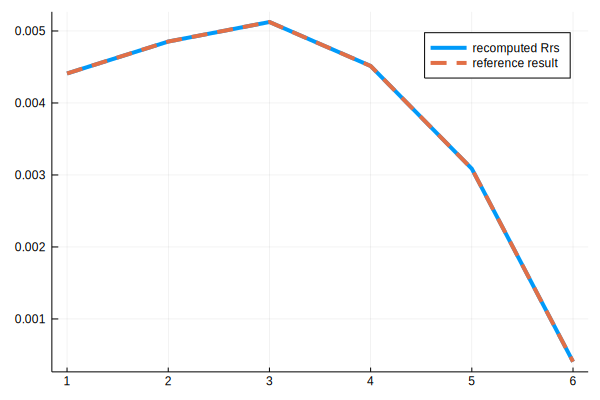

In [7]:
plot(vec(Rrs),linewidth=4,lab="recomputed Rrs")
plot!(ref_Rrs,linewidth=4,ls=:dash,lab="reference result")

### Estimate chlorophyll  from reflectances

Satellite `Chl_a` estimates provided by `OC-CCI` derive from `Rrs` using the blue/green reflectance ratio method as done with model output in the next code bloc (See [Dutkiewicz et al 2018](https://doi.org/10.5194/bg-15-613-2018) for details).

In [8]:
RRSB=max.(Rrs[:,:,2],Rrs[:,:,3]) #blue
RRSG=Rrs[:,:,5] #green
X = log10.(RRSB./RRSG) #ratio of blue to green

C=[0.3272, -2.9940, +2.7218, -1.2259, -0.5683] #OC4 algorithms (SeaWifs, CCI)
a0=C[1]; a1=C[2]; a2=C[3]; a3=C[4]; a4=C[5];
chld=exp10.(a0.+a1*X+a2*X.^2+a3*X.^3+a4*X.^4); #apply polynomial recipe

### Optical classification using reflectances

`Fuzzy logic` classifiers defined in [Moore et al 2009](https://doi.org/10.1016/j.rse.2009.07.016) and [Jackson et al 2017](http://dx.doi.org/10.1016/j.rse.2017.03.036) can be used to assign optical class memberships from an `Rrs` vector. While Moore et al define `n=8` classes using an in-situ database, Jackson et al instead define `n=14` classes using a satellite database. The latter benefits from better data coverage across all of the ecological provinces of the global ocean and is used in `OC-CCI`. 

In both cases the classifier is encoded in a mean reflectance spectra (`M[i][1:6]`) and a covariance matrix (`S[i][1:6,1:6]`) provided for each optical class (`i` in `1:n`). Class memberships are then derived by computing the squared Mahalanobis distance to each `M[i]` and passing the result to cumulative chi-squared distribution function (Equations 11 and 12 in [Moore et al 2011](https://doi.org/10.1109/36.942555)).

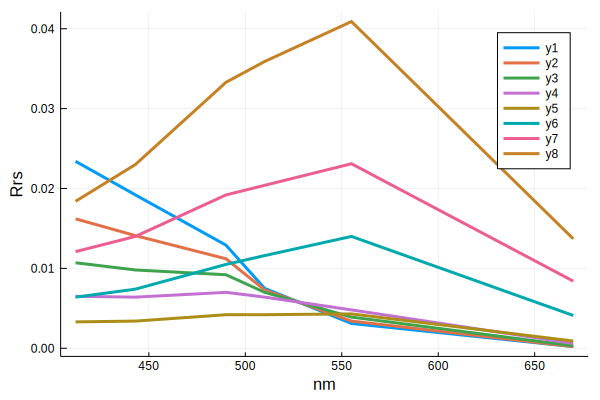

In [9]:
#Moore et al 2009:
include("../samples/M09.jl")

M09=Dict("M" => M, "S" => S, "Sinv" => inv.(S))
plot(wv_cci,M,w=3); xlabel!("nm"); ylabel!("Rrs")

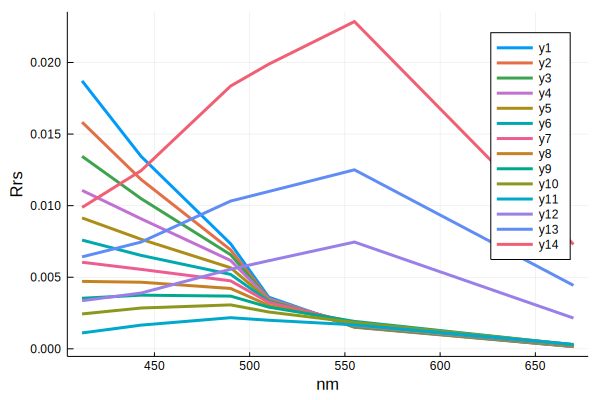

In [10]:
#Jackson et al 2017:
tmpM = ncread("../samples/J17.nc", "cluster_means")
tmpSinv = ncread("../samples/J17.nc", "inverse_covariance")

M=Array{Any,1}(undef,14)
Sinv=Array{Any,1}(undef,14)
for ii=1:length(M)
    M[ii]=vec(tmpM[ii,:])
    Sinv[ii]=tmpSinv[1:6,1:6,ii]
end

J17=Dict("M" => M, "Sinv" => Sinv, "S" => inv.(Sinv))
plot(wv_cci,M,w=3); xlabel!("nm"); ylabel!("Rrs")

### Compute class memberships

The `fcm` function below takes in a classifier matrix (`M` + `Sinv`) along with a vector of remotely sensed reflectcances (`Rrs`) as input and returns a membership vector (values between 0 and 1). 

In [11]:
function fcm(M,Sinv,Rrs)
    f=Array{Any,1}(undef,length(M))
    for ii=1:length(M)
        X=vec(Rrs)-M[ii]
        Z=transpose(X)*Sinv[ii]*X
        f[ii]=ccdf(Chisq(6),Z)
    end
    f
end

fcm (generic function with 1 method)

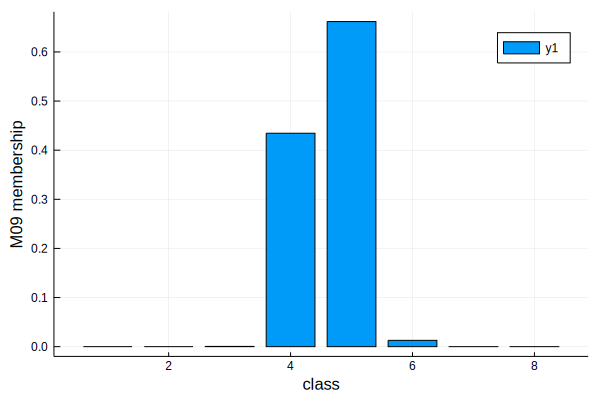

In [12]:
M09["Membership"]=fcm(M09["M"],M09["Sinv"],Rrs)
bar(M09["Membership"]); xlabel!("class"); ylabel!("M09 membership")

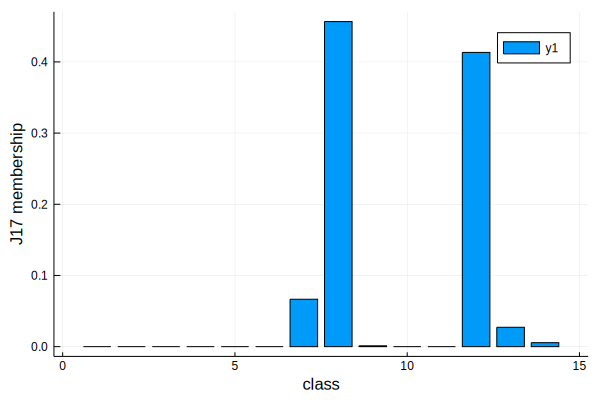

In [13]:
J17["Membership"]=fcm(J17["M"],J17["Sinv"],Rrs)
bar(J17["Membership"]); xlabel!("class"); ylabel!("J17 membership")